# **Modelo final - Grupo03**

## **Authors**
- César López Mantecón - 100472092
- Manuel Gómez-Plana Rodríguez - 100472310

## **Repositorio**
Esta práctica se ha llevado a cabo en [este repositorio de github](https://github.com/CLopMan/aprendizajeAutomatico-G03)

## Introducción 
En este cuaderno se resolverá un problema similar. Las instancias de energía se han clasificado en "low" o "high" según si su valor es inferior o superior al valor del tercer cuartil. En este cuaderno trataremos de entrenar un modelo capaz de clasificar nuevas instancias en estas clases. 


In [1]:
import pandas as pd 


raw_data = pd.read_csv("wind_ava.csv.gz", compression='gzip') 
sotavento = raw_data.filter(regex='13$|energy|datetime') # eliminacion de instancias no referentes a Sotavento

Q3 = sotavento["energy"].quantile(0.75)
sotavento.insert(1, "energyTag", ["high" for i in range(len(sotavento))])

def myfunc(v):
    if v < Q3:
        return "low"
    else:
        return "high"
cont = 0
for i, v in enumerate(sotavento["energy"]):
    if v < Q3:
        sotavento.loc[i, "energyTag"] = "low"
        cont += 1
sotavento = sotavento.drop("energy", axis=1)


## Clases desbalanceadas
Si observamos los valores de `energyTag`, la nueva columna del dataframe que indica la clase de cada instancia, podemos ver que las clases están desbalanceadas. 

Número de instancias 'low': 3561
Número de instancias 'high':1187


<Axes: ylabel='count'>

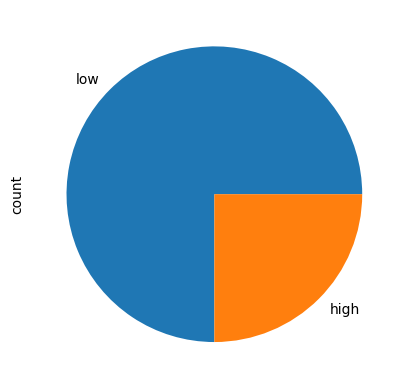

In [2]:
print(f"Número de instancias \'low\': {cont}\nNúmero de instancias \'high\':{len(sotavento) - cont}")

sotavento["energyTag"].value_counts().plot(kind="pie")

# División entre train y test 

In [3]:
from sklearn.model_selection import train_test_split

size = 0

res = pd.to_datetime(sotavento["datetime"], unit='ns').astype(str)

for ind, data in res.items():
  if data.startswith("2008") or data.startswith("2009"):
    size += 1

print("Hay", str(size), "instancias de 2008 y 2009")

# Se obtienen los datos
X = sotavento.drop(["energyTag", "datetime"], axis="columns")
Y = sotavento[["energyTag"]]

train, test = train_test_split(sotavento, test_size=size, shuffle=False)

X_train = train.drop(["energyTag", "datetime"], axis="columns")
Y_train = train[["energyTag"]]
X_test = test.drop(["energyTag", "datetime"], axis="columns")
Y_test = test[["energyTag"]]

Hay 1099 instancias de 2008 y 2009


# SMOTE 
Debido al desbalanceo entre clases es necesario utilizar algún mecanismo para evitar que el modelo final esté sesgado. 

After OverSampling, the shape of train_X: (5492, 22)
After OverSampling, the shape of train_y: (5492, 1) 



<Axes: ylabel='count'>

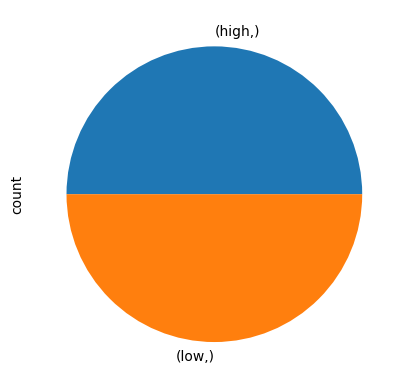

In [4]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 100472310) 
X_train_res, y_train_res = sm.fit_resample(X_train, Y_train) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  

y_train_res.value_counts().plot(kind="pie")


# Evaluación del modelo 

## Evaluación Inner
Utilizaremos validación cruzada con k = 3. 
Descartamos usar time series split debido a la nueva naturaleza del problema. 

## Evaluación Outer

Para evaular el modelo utilizaremos la métrica de `F1-score` debido a que se trata de un problema con clases desbalanceadas. Esta métrica no es sensible al desequilibrio de clases.  

# Modelos


In [5]:
f1_score = {}
train_time = {}

In [10]:
# Knn 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from time import time


pipe = Pipeline([
      ('scaler', StandardScaler()),
      ('knn', KNeighborsClassifier())
      ])

# Se crean los parametros
param_grid = {"knn__n_neighbors": list(range(10, 40, 2)),
              "knn__weights": ["uniform", "distance"],
              "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "knn__metric": ["euclidean", "manhattan", "chebyshev"]
              }

# Se realiza la HPO
grid = GridSearchCV(pipe,
                    param_grid,
                    cv=3,
                    scoring="f1_micro",
                    verbose=1,
                    n_jobs=-1)
start = time()
grid.fit(X_train, Y_train.values.ravel())
end = time()

print("\nLos mejores parámetros son:\n", grid.best_params_, "\n")



f1_score["knn"] = grid.best_score_

print(f"f1-score: {grid.best_score_}")
print("Tiempo de entrenamiento:", str(round(end-start, 2)) + "s.")
train_time["knn"] = end - start 

Fitting 3 folds for each of 360 candidates, totalling 1080 fits

Los mejores parámetros son:
 {'knn__algorithm': 'auto', 'knn__metric': 'manhattan', 'knn__n_neighbors': 27, 'knn__weights': 'uniform'} 

f1-score: 0.8514682350906023
Tiempo de entrenamiento: 11.36s.
